In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import gc
import sys
import re
import random
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import class_weight

import nltk
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

sys.path.insert(0, "../../")
from common import data_utils as data_utils

In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  

print(dev)
device = torch.device(dev)

cuda:0


In [3]:
folder = ""

In [4]:
# URI as text
uri_encoding = "utf-8"
out_uri_encoding = "utf-8"
output_file_normal = "uri_all_normal_wordlevel.txt"
output_file_abnormal = "uri_all_abnormal_wordlevel.txt"

In [5]:
def read(file):
    with open(str(folder + file), 'r', encoding=uri_encoding, errors="backslashreplace") as f:
        samples = list(f)
        return samples

## NORMAL GENERATION

In [6]:
good_uris = read("uri_all_normal.txt")
len(good_uris)

1401537

## ABNORMAL GENERATION

In [7]:
bad_uris = read("uri_all_abnormal.txt")
len(bad_uris)

87904

In [8]:
all_uris = []
all_uris.extend(good_uris)
all_uris.extend(bad_uris)
len(all_uris)

1489441

In [9]:
y = np.concatenate((np.zeros(len(good_uris)), np.ones(len(bad_uris))))

In [10]:
x_train, x_test, y_train, y_test = train_test_split(all_uris, y, test_size=0.20)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20)

In [12]:
# Tokenizer
# Stopwords removal
# Steming 

In [13]:
stopwords = ['']
wnl = WordNetLemmatizer()
def tokenizer_custom(uri):
    uri = str(uri)
    uri = uri.lower()
    #uri = re.sub(r"\\x[\W][\d+]", "/hexa",  uri.lower())
    uri = re.sub(r"[\d+]|\n", "",  uri)
    uri = re.split('(\/|\?|=|&|%|\+|-|\.|,|_|~|\*|<|>| |\:)',  uri)
    uri = [ wnl.lemmatize(word) for word in uri if word not in stopwords]
    #tienda/
    #{w}/
    #tienda=
    return uri

In [14]:
try:
    print("Loading")
    tf_vectorizer = joblib.load("vectorizer.joblib")
    tf = tf_vectorizer.transform(x_train)
except:
    print("Calculating")
    tf_vectorizer = TfidfVectorizer(max_features=500, tokenizer=tokenizer_custom, norm='l1')
    tf = tf_vectorizer.fit_transform(x_train)
    joblib.dump(tf_vectorizer, "vectorizer.joblib")
    #tf_vectorizer.vocabulary_

Loading


In [15]:
x_train = tf.todense()
x_train.shape

(953241, 500)

In [16]:
x_val = tf_vectorizer.transform(x_val).todense()
x_test = tf_vectorizer.transform(x_test).todense()

In [17]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
class_weights

array([0.53127546, 8.49348671])

In [18]:
def get_mechanism(eps):
    
    def test_randomizer(row):
        return row
    
    def laplace_randomizer(row):
        scale = 2/eps
        noise = np.random.laplace(0, scale, row.shape)
        return row + noise
    
    return laplace_randomizer
    
def privatize_matrix(data, randomizer):
    return np.apply_along_axis(randomizer, axis=1, arr=data)

In [19]:
if False:
    print("privatizing")
    epsilon = 10
    x_train = privatize_matrix(x_train, get_mechanism(epsilon))
    x_val = privatize_matrix(x_val, get_mechanism(epsilon))
    x_test = privatize_matrix(x_test, get_mechanism(epsilon))

In [20]:
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val).to(device)
y_val = torch.FloatTensor(y_val).to(device)
x_test = torch.FloatTensor(x_test).to(device)
y_test = torch.FloatTensor(y_test)
weights = torch.FloatTensor(class_weights).to(device)

In [21]:
x_train

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2851, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [22]:
train_data = []
for i in range(len(x_train)):
    train_data.append([x_train[i], y_train[i], weights[int(y_train[i])]])

In [23]:
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

In [24]:

class Feedforward(torch.nn.Module):
    
    def __init__(self, input_size):
        super(Feedforward, self).__init__()
        
        self.fc1 = nn.Linear(in_features=input_size, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [25]:
model = Feedforward(x_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001, weight_decay=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [26]:
model = model.to(device)

In [27]:
epoch = 10
history_train = []
history_val = []

for epoch in range(epoch):
    #Poner el modelo en modeo entrenamiento
    model.train()
    epoch_loss = 0
    for idx, batch in enumerate(train_dataloader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) 
        
        #Llevar gradientes a zero para calcularlos nuevamente
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(x_batch)

        # Computar Loss
        criterion.weight = batch[2]
        loss = criterion(y_pred.squeeze(), y_batch)
        epoch_loss += loss.item()
        print(f'Epoch {epoch}: batch {idx} train loss: {loss.item()}\r', end="")
  
        # Backward pass
        loss.backward()
        optimizer.step()
        
        del x_batch
        del y_batch
        

    #Evaluar loss en todo Train 
    epoch_mean = epoch_loss/len(train_dataloader)
    history_train.append(epoch_mean)
    
    model.eval()
    with torch.no_grad():
        #Evaluar loss en un val 
        y_pred_val = model(x_val)
        criterion.weight = None
        loss_val = criterion(y_pred_val.squeeze(), y_val)
        history_val.append(loss_val.item())
        print(f'Epoch {epoch}: train loss: {epoch_mean} : val_loss: {loss_val}')


Epoch 0: train loss: 0.5026428882736876 : val_loss: 0.3353259265422821
Epoch 1: train loss: 0.30820123053623 : val_loss: 0.291858434677124
Epoch 2: train loss: 0.28084337846681107 : val_loss: 0.2769607603549957
Epoch 3: train loss: 0.2673020470891424 : val_loss: 0.2735089957714081
Epoch 4: train loss: 0.2585019187353527 : val_loss: 0.2614022195339203
Epoch 5: train loss: 0.2534934352497169 : val_loss: 0.25816813111305237
Epoch 6: train loss: 0.24989405646920204 : val_loss: 0.2570640444755554
Epoch 7: train loss: 0.24728761711202873 : val_loss: 0.24539437890052795
Epoch 8: train loss: 0.24543676516751406 : val_loss: 0.24829283356666565
Epoch 9: train loss: 0.24406723483444603 : val_loss: 0.2450621873140335


NameError: name 'weight' is not defined

In [45]:
del loss_val
del y_pred_val
del y_pred
del loss
del weights
torch.cuda.empty_cache()
gc.collect()

NameError: name 'loss_val' is not defined

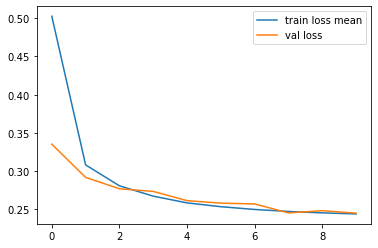

In [30]:
#plt.axis([0, 3000, 0, 200])
plt.plot(history_train, label='train loss mean')
plt.plot(history_val, label='val loss')
plt.legend()
plt.show()

In [47]:
model.eval()
y_pred_test = model(x_test)
y_pred_test = y_pred_test.squeeze().cpu().detach().numpy()

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.486523

In [49]:
y_hat = y_pred_test.squeeze() > optimal_threshold

In [50]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
print(tn, fp, fn, tp)

254047 26241 897 16704


In [51]:
tpr = tp / (tp + fn)
tpr

0.949036986534856

In [52]:
tnr = tn / (tn + fp)
tnr

0.906378439319557